In [1]:
#this has the averaging rolling but using decay functions. Changing to a new notebook to \

In [2]:
# the tensorflow version of the wong/wang dynamics that only uses a TF version of the controller
#the rest is in numpy 
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import math
from tf_funs import * #EKF, and helper in tensorflow
from threechoice_dynamics_decay import * #the gradients for wong/wang dynamics

tf.set_random_seed(101)
np.random.seed(101)
pi = math.pi

session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=4,
      inter_op_parallelism_threads=4)
sess = tf.Session(config=session_conf)

#build graphs
xdim = 2 #state dimension
udim = 2 #control dimension
X_est = tf.placeholder(shape=(xdim),dtype=tf.float32,name='X_est') #the state estimate
PI_est = tf.placeholder(shape = (xdim,xdim),dtype=tf.float32, name = 'PI_est') #estimated covariance
Y_tp1 = tf.placeholder(shape=(xdim),dtype=tf.float32, name = 'Y_tp1') #the most recent observation
Control = tf.placeholder(shape = udim, dtype=tf.float32, name='Control')

#define the noise for the system
dt = 1.0e-4
gamma = 1.0e-4
sigsstate = (1./dt)*(1e-9)
sigsobs = 1e-6

Q = sigsstate*np.eye(xdim)
Q_tf = tf.constant(Q,dtype=tf.float32, name = 'Q') #state noise covariance
R = sigsobs*np.eye(xdim)
R_tf = tf.constant(R,dtype=tf.float32, name = 'R') #observation noise covariance  

#graphs for updating state and observation
true_model_est = grad_threechoice_tf(X_est[0],X_est[1],dt,Control)
true_model_est_null = grad_threechoice_tf(X_est[0],X_est[1],dt,[0.,0.]) #state est. gradient null control
target_model_est = grad_threechoice_healthy_tf(X_est[0],X_est[1],dt) #state est. target dynamics
#the non-tensorflow anonymous functions, for generalizations
true_nontf = lambda x,c: grad_threechoice(x[0],x[1],dt,c)
target_nontf = lambda x: grad_threechoice_healthy(x[0],x[1],dt)   

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nana/opt/anaconda3/envs/latent_circuit/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-f832e384a194>", line 39, in <module>
    true_model_est = grad_threechoice_tf(X_est[0],X_est[1],dt,Control)
TypeError: grad_threechoice_tf() missing 1 required positional argument: 'responsiveness_factor'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nana/opt/anaconda3/envs/latent_circuit/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nana/opt/anaconda3/envs/latent_circuit/lib/python3.6/site-pac

In [ ]:
true_model_est

<tf.Tensor 'add_7:0' shape=(2,) dtype=float32>

In [ ]:


X_plus,PI_plus = EKF(X_est,Y_tp1,PI_est,true_model_est,true_model_est_null,Q_tf,R_tf,xdim,dt)

#myopic controller
#graphs for controller

useMO = 1
if useMO ==1:
    print('using mean-only control')
    Cnew = myopicController_meanonly(
        X_est,PI_est,Control,gamma,true_model_est,
        true_model_est_null,target_model_est,xdim,udim)
else:
    print('using full myopic control, but non-Jacobian-differential form')
    Cnew = myopicController_noBdiff(
        X_est,PI_est,Control,gamma,true_model_est,
        true_model_est_null,target_model_est,xdim,udim)

#covariance prediction update graph
Ak = dynamics_linearized(X_est,true_model_est_null,xdim)

#the full loss function, not just loss of mean values
loss_tf = loss_full(X_est,PI_est,true_model_est,target_model_est)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



using mean-only control





In [ ]:
#begin specifics of the simulation
T = 1000 #number of steps
ns = 1 #number of samples
window_size = 10 #number of steps to average over #HD

#make the numpy version of noise
statenoise = np.random.normal(0,sigsstate**0.5,[xdim,T,ns])
obsnoise = np.random.normal(0,sigsobs**0.5,[xdim,T,ns])
G = dt**(0.5)*np.eye(xdim) #system noise matrix, for covariance prediction

#vectors of interest
x_estvec = np.zeros((xdim,T,ns)) #state estimate
x_ucvec = np.zeros((xdim,T,ns)) #uncontrolled state
xvec = np.zeros((xdim,T,ns)) #actual controlled state
yvec = np.zeros((xdim,T,ns)) #observations related to state
x_targvec = np.zeros((xdim,T,ns)) #target state
PI_estvec = np.zeros((xdim,xdim,T,ns)) #estimated covariance
contall = np.zeros((udim,T,ns)) #control
power_buffer = np.zeros(window_size) # HD

#loss function values in vector form as
#(full loss, mean-only loss, jacobian loss term, Hessian term)
loss = np.zeros((4,T,ns))
loss_nocont = np.zeros((4,T,ns))
loss_true = np.zeros((T,ns))
initvals = np.zeros((xdim,ns))

power_ck_vec = np.zeros((T,ns))


lag = 1 #1+number of steps difference between observations and state estimate

init = tf.global_variables_initializer()

for m in range(ns):
    sess.run(init)
    x_init = np.random.uniform(0.1,0.2,(2,))
    initvals[:,m] = x_init
    PI_init = [[1.0e-6,0.],[0.,1.0e-6]] #initial covariance
    c_init = [0.,0.]

    xest_k = x_init
    pi_k = PI_init
    c_k = c_init
    x_k = x_init
    x_targ_k = x_init
    ykp1 = np.array(x_init)

    x_estvec[:,0,m] = x_init
    xvec[:,0,m] = x_init
    x_ucvec[:,0,m] = x_init
    x_targvec[:,0,m] = x_init
    PI_estvec[:,:,0,m] = PI_init
    
    #go ahead and propagate lag-steps ahead before starting state estimation and such
    for k in range(1,lag):
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],c_init)
        grad_targ = target_nontf(x_targvec[:,k-1,m])
        grad_uc = true_nontf(x_ucvec[:,k-1,m],c_init)

        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_ucvec[:,k,m] = x_ucvec[:,k-1,m] + grad_uc + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]

        #set estimates in beginning lags to initial state
        x_estvec[:,k,m] = x_init
        PI_estvec[:,:,k,m] = PI_init
    for k in range(max(1,lag),T): 
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],contall[:,k-1,m])
        grad_uc = true_nontf(x_ucvec[:,k-1,m],c_init)
        grad_targ = target_nontf(x_targvec[:,k-1,m])
        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_ucvec[:,k,m] = x_ucvec[:,k-1,m] + grad_uc + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]

        #run state estimator to update estimate of state k-lag
        test = sess.run([X_plus,PI_plus],
                        {X_est:x_estvec[:,k-lag,m], 
                         PI_est:PI_estvec[:,:,k-lag,m], 
                         Control:contall[:,k-lag,m],Y_tp1:yvec[:,k-lag+1,m]})
        x_estvec[:,k-lag+1,m] = test[0]
        PI_estvec[:,:,k-lag+1,m] = test[1]
        
        #predit lag states in the future to calculate control
        x_est_n = x_estvec[:,k-lag+1,m]
        PI_est_n = PI_estvec[:,:,k-lag+1,m]
        
        for n in range(1,lag):
            #state prediction step
            grad_cont = true_nontf(x_est_n,contall[:,k-lag-n,m])

            #covariance prediction step. calculate jacobian
            Ak_n= sess.run(Ak,
                        {X_est: x_est_n, PI_est: PI_est_n,
                         Control: contall[:,0,m], Y_tp1:yvec[:,0,m]})

            x_est_n = x_est_n + grad_cont
            PI_est_n = np.matmul(Ak_n,PI_est_n) + np.matmul(PI_est_n,np.transpose(Ak_n)) + np.matmul(
                np.matmul(G,Q),np.transpose(G))

        #run myopic controller using predicted state estimated. cov, doesnt matter
        #find control for time k
        c_k = sess.run(Cnew,{X_est:x_est_n, PI_est:PI_est_n,
                             Control:contall[:,k-1,m], Y_tp1:yvec[:,k,m]})
        
        #added section for max power
        p_max = 0.00275
        # power_ck = np.sum(c_k**2)
        # power_ck_vec[k,m] = power_ck
        # # if power_ck > P_max:
        # #     print('power_ck:',power_ck)
        # #     print('P_max:',P_max)
        # #     c_k = c_k*np.sqrt(P_max/power_ck)


        # Inside your main loop, after calculating the new control signal 'c_k'
        current_power = np.sum(c_k**2)
        power_buffer = np.roll(power_buffer, -1)  # Shift the window
        power_buffer[-1] = current_power  # Add the new power at the end of the window
        rolling_average_power = np.mean(power_buffer)

        if rolling_average_power > p_max:
            scale_factor = np.sqrt(p_max / rolling_average_power)
            c_k = c_k * scale_factor


        #print('power_ck:',power_ck)

        #do quick comparison for jumps in control due to a singularity in dynamics

        if abs(np.linalg.norm(c_k)) > 100.:
            contall[:,k,m] = contall[:,k-1,m]
            print('dynamics likely got singular. hold tight')
            print(k)
        else:
             contall[:,k,m] = c_k
        
        #calcualte loss functions
        #true loss from actual state
        loss_true[k-lag+1,m] = np.linalg.norm(true_nontf(xvec[:,k-lag+1,m],contall[:,k-lag+1,m])-
        target_nontf(xvec[:,k-lag+1,m]))**2
        
        #approximated loss from estimated state
        ltest = sess.run(loss_tf,{X_est:x_estvec[:,k-lag+1,m],
                                               PI_est:PI_estvec[:,:,k-lag+1,m],
                                               Control:contall[:,k-lag+1,m]
                                              })
        loss[:,k-lag+1,m] = ltest
        
        #approximated loss from estimated state, no control
        ltest = sess.run(loss_tf,{X_est:x_estvec[:,k-lag+1,m],
                                               PI_est:PI_estvec[:,:,k-lag+1,m],
                                               Control:np.array([0.,0.])
                                              })
        loss_nocont[:,k-lag+1,m] = ltest
        
        
    #set final lag estimate values to esimate
    for k in range(lag-1):
        x_targvec[:,T-lag+1+k,m] = x_targvec[:,T-lag,m]
        x_estvec[:,T-lag+1+k,m] = x_estvec[:,T-lag,m]
        x_ucvec[:,T-lag+1+k,m] = x_ucvec[:,T-lag,m]
        PI_estvec[:,:,T-lag+1+k,m] = PI_estvec[:,:,T-lag,m]

In [ ]:
#plt.plot(power_ck_vec)

In [ ]:
np.max(power_ck_vec)

0.0

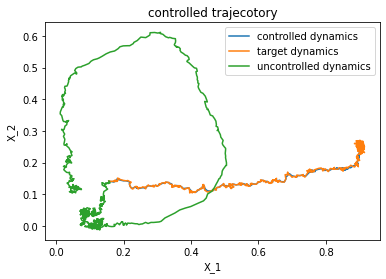

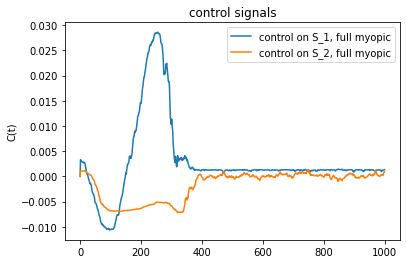

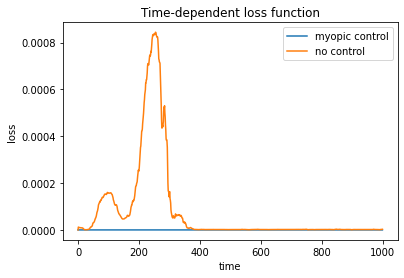

In [ ]:
#true state
tind = 0
plt.plot(x_estvec[0,:,tind],x_estvec[1,:,tind],label='controlled dynamics')
plt.plot(x_targvec[0,:,tind],x_targvec[1,:,tind],label = 'target dynamics')
plt.plot(x_ucvec[0,:,tind],x_ucvec[1,:,tind],label = 'uncontrolled dynamics')
plt.legend()
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.title('controlled trajecotory')
plt.show()

plt.plot(contall[0,:,tind],label='control on S_1, full myopic')
plt.plot(contall[1,:,tind],label='control on S_2, full myopic')
plt.ylabel('C(t)')
plt.title('control signals')
plt.legend()
plt.show()

#expected state
fullloss = plt.plot(loss[0,:,tind],label='myopic control')
nocontloss = plt.plot(loss_nocont[0,:,tind],label='no control')

plt.xlabel('time')
plt.ylabel('loss')
plt.title('Time-dependent loss function')
plt.legend()
plt.show()



## Gain Tuning

Feedback Loop Enhancement: Introduce more sophisticated feedback mechanisms, such as non-linear control laws or gain scheduling, where control parameters change based on the system's state.

State Estimation Accuracy: Improve the accuracy of the state estimation by refining the model used in the EKF. Better state estimation can result in more accurate control actions.

Control Law Modifications: Alter the structure of the control law itself. For example, introduce derivative control to provide damping or use integral control to eliminate steady-state errors.

Adding Heuristics: Include heuristic rules based on domain knowledge that can improve control actions. For instance, if you know certain states are particularly problematic, you could add rules to handle these explicitly.

Learning from Past Performance: Implement a learning mechanism that adjusts control parameters based on past performance. This is not predictive control, but rather a retrospective adjustment to improve future performance.

Noise Filtering: Improve the noise filtering in the observations fed into the control algorithm. If the control input is noisy, it could lead to erratic behavior.

Robust Control Techniques: Employ robust control techniques that are designed to perform well in the face of uncertainty and system variability.

Action Smoothing: If the control action is jumping erratically, introduce a smoothing factor to make changes more gradual and prevent sudden shifts.

Simulation-Based Optimization: Use simulations to optimize the control parameters for the most common scenarios that the system faces.